# Create Submission From Model

Run inference on the test images to create results ready for submission. This will create a folder called `submission` in the current directory.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, torchvision
torch.__version__

'1.3.0'

In [3]:
from detectron2.evaluation.xview_evaluation import *

In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import os
import numpy as np
import json
import shutil
import cv2
import random
import glob

import matplotlib.pyplot as plt
%matplotlib inline

/home/ethanweber/anaconda3/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [5]:
# Set some parameters.
LOCALIZATION_SUBMISSION_FOLDER = "SUBMISSION_LOCALIZATION"
LOCALIZATION_MODEL_CONFIG = "./detectron2_repo/configs/xview/mask_rcnn_R_50_FPN_1x-localization.yaml"
DAMAGE_SUBMISSION_FOLDER = "SUBMISSION_DAMAGE"
DAMAGE_MODEL_CONFIG = "./detectron2_repo/configs/xview/mask_rcnn_R_50_FPN_1x-damage.yaml"

In [6]:
# Removes and creates folders (clears them).
shutil.rmtree(LOCALIZATION_SUBMISSION_FOLDER, ignore_errors=True)
shutil.rmtree(DAMAGE_SUBMISSION_FOLDER, ignore_errors=True)
os.mkdir(LOCALIZATION_SUBMISSION_FOLDER)
os.mkdir(DAMAGE_SUBMISSION_FOLDER)

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# Load localization model.
# cfg_localization = get_cfg()
# cfg_localization.merge_from_file(LOCALIZATION_MODEL_CONFIG)
# # Load localization checkpoint.
# cfg_localization.MODEL.WEIGHTS = os.path.join(cfg_localization.OUTPUT_DIR, "model_0054999.pth")
# cfg_localization.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set the testing threshold for this model
# predictor_localization = DefaultPredictor(cfg_localization)

# Load damage model.
cfg_damage = get_cfg()
cfg_damage.merge_from_file(DAMAGE_MODEL_CONFIG)
# Load damage checkpoint.
cfg_damage.MODEL.WEIGHTS = os.path.join(cfg_damage.OUTPUT_DIR, "model_0014999.pth")
cfg_damage.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set the testing threshold for this model
predictor_damage = DefaultPredictor(cfg_damage)

WARNING [12/16 01:52:49 d2.config.compat]: Config './detectron2_repo/configs/xview/mask_rcnn_R_50_FPN_1x-damage.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [8]:
image_filenames = sorted(glob.glob("data/test/images/*"))
for filename in image_filenames:
    # Load the image.
    image = cv2.imread(filename)
    
    # Choose the model type based on pre or post localization
    if filename.find("pre") >= 0:
        # LOCALIZATION model.
#         outputs = predictor_localization(image)
    
#         # get to the right format
#         instances = outputs["instances"].to('cpu')
#         # use RLE to encode the masks, because they are too large and takes memory
#         # since this evaluator stores outputs of the entire dataset
#         # Our model may predict bool array, but cocoapi expects uint8
#         rles = [
#             mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
#             for mask in instances.pred_masks
#         ]
#         for rle in rles:
#             # "counts" is an array encoded by mask_util as a byte-stream. Python3's
#             # json writer which always produces strings cannot serialize a bytestream
#             # unless you decode it. Thankfully, utf-8 works out (which is also what
#             # the pycocotools/_mask.pyx does).
#             rle["counts"] = rle["counts"].decode("utf-8")
#         instances.pred_masks_rle = rles
#         instances.remove("pred_masks")
#         prediction = {}
#         prediction["instances"] = instances_to_json(instances)
#         height = 1024
#         width = 1024
        
#         pred_image = get_xview_localization_pred_image(height, width, prediction)
        
        name = os.path.basename(filename)
        new_filename = name.replace("pre", "localization")[:-4] + "_prediction.png"
        submission_filename = os.path.join(LOCALIZATION_SUBMISSION_FOLDER, new_filename)
        print(submission_filename)
        pred_image = np.zeros((1024, 1024))
        cv2.imwrite(submission_filename, pred_image)
        
    elif filename.find("post") >= 0:
        # DAMAGE model.
        outputs = predictor_damage(image)
    
        # get to the right format
        instances = outputs["instances"].to('cpu')
        # use RLE to encode the masks, because they are too large and takes memory
        # since this evaluator stores outputs of the entire dataset
        # Our model may predict bool array, but cocoapi expects uint8
        rles = [
            mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
            for mask in instances.pred_masks
        ]
        for rle in rles:
            # "counts" is an array encoded by mask_util as a byte-stream. Python3's
            # json writer which always produces strings cannot serialize a bytestream
            # unless you decode it. Thankfully, utf-8 works out (which is also what
            # the pycocotools/_mask.pyx does).
            rle["counts"] = rle["counts"].decode("utf-8")
        instances.pred_masks_rle = rles
        instances.remove("pred_masks")
        prediction = {}
        prediction["instances"] = instances_to_json(instances)
        height = 1024
        width = 1024
        
        pred_image = get_xview_damage_pred_image(height, width, prediction)
        
        name = os.path.basename(filename)
        new_filename = name.replace("post", "damage")[:-4] + "_prediction.png"
        submission_filename = os.path.join(DAMAGE_SUBMISSION_FOLDER, new_filename)
        
        print(submission_filename)
        cv2.imwrite(submission_filename, pred_image)



SUBMISSION_DAMAGE/test_damage_00000_prediction.png
SUBMISSION_DAMAGE/test_damage_00001_prediction.png
SUBMISSION_DAMAGE/test_damage_00002_prediction.png
SUBMISSION_DAMAGE/test_damage_00003_prediction.png
SUBMISSION_DAMAGE/test_damage_00004_prediction.png
SUBMISSION_DAMAGE/test_damage_00005_prediction.png
SUBMISSION_DAMAGE/test_damage_00006_prediction.png
SUBMISSION_DAMAGE/test_damage_00007_prediction.png
SUBMISSION_DAMAGE/test_damage_00008_prediction.png
SUBMISSION_DAMAGE/test_damage_00009_prediction.png
SUBMISSION_DAMAGE/test_damage_00010_prediction.png
SUBMISSION_DAMAGE/test_damage_00011_prediction.png
SUBMISSION_DAMAGE/test_damage_00012_prediction.png
SUBMISSION_DAMAGE/test_damage_00013_prediction.png
SUBMISSION_DAMAGE/test_damage_00014_prediction.png
SUBMISSION_DAMAGE/test_damage_00015_prediction.png
SUBMISSION_DAMAGE/test_damage_00016_prediction.png
SUBMISSION_DAMAGE/test_damage_00017_prediction.png
SUBMISSION_DAMAGE/test_damage_00018_prediction.png
SUBMISSION_DAMAGE/test_damage_0

SUBMISSION_DAMAGE/test_damage_00161_prediction.png
SUBMISSION_DAMAGE/test_damage_00162_prediction.png
SUBMISSION_DAMAGE/test_damage_00163_prediction.png
SUBMISSION_DAMAGE/test_damage_00164_prediction.png
SUBMISSION_DAMAGE/test_damage_00165_prediction.png
SUBMISSION_DAMAGE/test_damage_00166_prediction.png
SUBMISSION_DAMAGE/test_damage_00167_prediction.png
SUBMISSION_DAMAGE/test_damage_00168_prediction.png
SUBMISSION_DAMAGE/test_damage_00169_prediction.png
SUBMISSION_DAMAGE/test_damage_00170_prediction.png
SUBMISSION_DAMAGE/test_damage_00171_prediction.png
SUBMISSION_DAMAGE/test_damage_00172_prediction.png
SUBMISSION_DAMAGE/test_damage_00173_prediction.png
SUBMISSION_DAMAGE/test_damage_00174_prediction.png
SUBMISSION_DAMAGE/test_damage_00175_prediction.png
SUBMISSION_DAMAGE/test_damage_00176_prediction.png
SUBMISSION_DAMAGE/test_damage_00177_prediction.png
SUBMISSION_DAMAGE/test_damage_00178_prediction.png
SUBMISSION_DAMAGE/test_damage_00179_prediction.png
SUBMISSION_DAMAGE/test_damage_0

SUBMISSION_DAMAGE/test_damage_00323_prediction.png
SUBMISSION_DAMAGE/test_damage_00324_prediction.png
SUBMISSION_DAMAGE/test_damage_00325_prediction.png
SUBMISSION_DAMAGE/test_damage_00326_prediction.png
SUBMISSION_DAMAGE/test_damage_00327_prediction.png
SUBMISSION_DAMAGE/test_damage_00328_prediction.png
SUBMISSION_DAMAGE/test_damage_00329_prediction.png
SUBMISSION_DAMAGE/test_damage_00330_prediction.png
SUBMISSION_DAMAGE/test_damage_00331_prediction.png
SUBMISSION_DAMAGE/test_damage_00332_prediction.png
SUBMISSION_DAMAGE/test_damage_00333_prediction.png
SUBMISSION_DAMAGE/test_damage_00334_prediction.png
SUBMISSION_DAMAGE/test_damage_00335_prediction.png
SUBMISSION_DAMAGE/test_damage_00336_prediction.png
SUBMISSION_DAMAGE/test_damage_00337_prediction.png
SUBMISSION_DAMAGE/test_damage_00338_prediction.png
SUBMISSION_DAMAGE/test_damage_00339_prediction.png
SUBMISSION_DAMAGE/test_damage_00340_prediction.png
SUBMISSION_DAMAGE/test_damage_00341_prediction.png
SUBMISSION_DAMAGE/test_damage_0

SUBMISSION_DAMAGE/test_damage_00485_prediction.png
SUBMISSION_DAMAGE/test_damage_00486_prediction.png
SUBMISSION_DAMAGE/test_damage_00487_prediction.png
SUBMISSION_DAMAGE/test_damage_00488_prediction.png
SUBMISSION_DAMAGE/test_damage_00489_prediction.png
SUBMISSION_DAMAGE/test_damage_00490_prediction.png
SUBMISSION_DAMAGE/test_damage_00491_prediction.png
SUBMISSION_DAMAGE/test_damage_00492_prediction.png
SUBMISSION_DAMAGE/test_damage_00493_prediction.png
SUBMISSION_DAMAGE/test_damage_00494_prediction.png
SUBMISSION_DAMAGE/test_damage_00495_prediction.png
SUBMISSION_DAMAGE/test_damage_00496_prediction.png
SUBMISSION_DAMAGE/test_damage_00497_prediction.png
SUBMISSION_DAMAGE/test_damage_00498_prediction.png
SUBMISSION_DAMAGE/test_damage_00499_prediction.png
SUBMISSION_DAMAGE/test_damage_00500_prediction.png
SUBMISSION_DAMAGE/test_damage_00501_prediction.png
SUBMISSION_DAMAGE/test_damage_00502_prediction.png
SUBMISSION_DAMAGE/test_damage_00503_prediction.png
SUBMISSION_DAMAGE/test_damage_0

SUBMISSION_DAMAGE/test_damage_00646_prediction.png
SUBMISSION_DAMAGE/test_damage_00647_prediction.png
SUBMISSION_DAMAGE/test_damage_00648_prediction.png
SUBMISSION_DAMAGE/test_damage_00649_prediction.png
SUBMISSION_DAMAGE/test_damage_00650_prediction.png
SUBMISSION_DAMAGE/test_damage_00651_prediction.png
SUBMISSION_DAMAGE/test_damage_00652_prediction.png
SUBMISSION_DAMAGE/test_damage_00653_prediction.png
SUBMISSION_DAMAGE/test_damage_00654_prediction.png
SUBMISSION_DAMAGE/test_damage_00655_prediction.png
SUBMISSION_DAMAGE/test_damage_00656_prediction.png
SUBMISSION_DAMAGE/test_damage_00657_prediction.png
SUBMISSION_DAMAGE/test_damage_00658_prediction.png
SUBMISSION_DAMAGE/test_damage_00659_prediction.png
SUBMISSION_DAMAGE/test_damage_00660_prediction.png
SUBMISSION_DAMAGE/test_damage_00661_prediction.png
SUBMISSION_DAMAGE/test_damage_00662_prediction.png
SUBMISSION_DAMAGE/test_damage_00663_prediction.png
SUBMISSION_DAMAGE/test_damage_00664_prediction.png
SUBMISSION_DAMAGE/test_damage_0

SUBMISSION_DAMAGE/test_damage_00808_prediction.png
SUBMISSION_DAMAGE/test_damage_00809_prediction.png
SUBMISSION_DAMAGE/test_damage_00810_prediction.png
SUBMISSION_DAMAGE/test_damage_00811_prediction.png
SUBMISSION_DAMAGE/test_damage_00812_prediction.png
SUBMISSION_DAMAGE/test_damage_00813_prediction.png
SUBMISSION_DAMAGE/test_damage_00814_prediction.png
SUBMISSION_DAMAGE/test_damage_00815_prediction.png
SUBMISSION_DAMAGE/test_damage_00816_prediction.png
SUBMISSION_DAMAGE/test_damage_00817_prediction.png
SUBMISSION_DAMAGE/test_damage_00818_prediction.png
SUBMISSION_DAMAGE/test_damage_00819_prediction.png
SUBMISSION_DAMAGE/test_damage_00820_prediction.png
SUBMISSION_DAMAGE/test_damage_00821_prediction.png
SUBMISSION_DAMAGE/test_damage_00822_prediction.png
SUBMISSION_DAMAGE/test_damage_00823_prediction.png
SUBMISSION_DAMAGE/test_damage_00824_prediction.png
SUBMISSION_DAMAGE/test_damage_00825_prediction.png
SUBMISSION_DAMAGE/test_damage_00826_prediction.png
SUBMISSION_DAMAGE/test_damage_0

SUBMISSION_LOCALIZATION/test_localization_00039_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00040_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00041_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00042_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00043_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00044_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00045_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00046_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00047_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00048_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00049_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00050_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00051_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00052_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00053_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00054_predict

SUBMISSION_LOCALIZATION/test_localization_00176_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00177_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00178_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00179_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00180_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00181_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00182_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00183_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00184_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00185_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00186_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00187_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00188_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00189_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00190_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00191_predict

SUBMISSION_LOCALIZATION/test_localization_00313_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00314_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00315_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00316_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00317_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00318_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00319_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00320_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00321_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00322_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00323_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00324_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00325_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00326_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00327_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00328_predict

SUBMISSION_LOCALIZATION/test_localization_00452_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00453_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00454_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00455_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00456_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00457_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00458_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00459_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00460_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00461_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00462_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00463_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00464_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00465_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00466_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00467_predict

SUBMISSION_LOCALIZATION/test_localization_00587_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00588_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00589_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00590_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00591_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00592_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00593_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00594_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00595_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00596_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00597_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00598_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00599_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00600_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00601_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00602_predict

SUBMISSION_LOCALIZATION/test_localization_00729_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00730_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00731_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00732_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00733_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00734_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00735_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00736_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00737_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00738_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00739_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00740_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00741_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00742_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00743_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00744_predict

SUBMISSION_LOCALIZATION/test_localization_00866_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00867_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00868_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00869_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00870_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00871_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00872_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00873_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00874_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00875_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00876_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00877_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00878_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00879_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00880_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00881_predict

In [40]:
i = cv2.imread("./SUBMISSION_DAMAGE/test_damage_00019_prediction.png")

In [41]:
np.max(i)

1

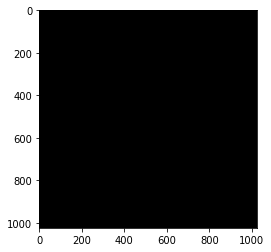

In [16]:
plt.imshow(i)

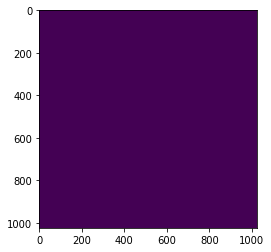

In [11]:
plt.imshow(pred_image)